In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from datetime import timedelta
from geopy.distance import geodesic
from tqdm import tqdm

from plotting import plot_time_distance, plot_matches_interactive_map, plot_single_interactive_map, \
    create_map_screenshot, plot_histogram, show_screenshots

matplotlib.use("module://matplotlib_inline.backend_inline")  # Keeps the backend interactive
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
})

In [2]:
# read data from CSVs
modis_data = pd.read_csv('data/modis_2023_Germany.csv')
viirs_data = pd.read_csv('data/viirs-snpp_2023_Germany.csv')

In [3]:
# add 'timestamp' column calculated from "acq_date" and "acq_time"
modis_data['timestamp'] = pd.to_datetime(
    modis_data['acq_date'] + ' ' + modis_data['acq_time'].apply(lambda x: str(x).zfill(4)), format='%Y-%m-%d %H%M')
viirs_data['timestamp'] = pd.to_datetime(
    viirs_data['acq_date'] + ' ' + viirs_data['acq_time'].apply(lambda x: str(x).zfill(4)), format='%Y-%m-%d %H%M')

In [4]:
# remove low confidence detections
modis_data_high_conf = modis_data[modis_data['confidence'] > 40]
viirs_data_high_conf = viirs_data[viirs_data['confidence'] != 'l']
aqua_only_data = modis_data_high_conf[modis_data_high_conf['satellite'] == 'Aqua']
terra_only_data = modis_data_high_conf[modis_data_high_conf['satellite'] == 'Terra']
modis_data_very_high_conf = modis_data[modis_data['confidence'] > 85]

In [5]:
def cluster_fire_detections(df, spatial_threshold_km=1.0, temporal_threshold_hours=24):
    """
    Cluster fire detections into distinct fire events based on spatial and temporal proximity.

    Parameters:
    df: pandas DataFrame with columns: latitude, longitude, timestamp
        (timestamp should be in datetime format)
    spatial_threshold_km: float, maximum distance between points in same cluster (km)
    temporal_threshold_hours: float, maximum time difference between points in same cluster (hours)

    Returns:
    DataFrame with additional column 'event_id' identifying distinct fire events
    """
    # Convert temporal threshold to timedelta
    temporal_threshold = timedelta(hours=temporal_threshold_hours)

    # Sort by timestamp to process events chronologically
    df = df.sort_values('timestamp').copy()

    # Prepare coordinates for DBSCAN
    coords = df[['latitude', 'longitude']].values

    # Convert spatial threshold from km to degrees (approximate)
    # 111 km = 1 degree at the equator
    eps_degrees = spatial_threshold_km / 111.0

    # Perform spatial clustering
    clustering = DBSCAN(eps=eps_degrees, min_samples=1).fit(coords)
    df['spatial_cluster'] = clustering.labels_

    # Initialize event IDs
    df['event_id'] = -1
    current_event_id = 0

    # Process each spatial cluster
    for spatial_cluster in df['spatial_cluster'].unique():
        cluster_mask = df['spatial_cluster'] == spatial_cluster
        cluster_data = df[cluster_mask].copy()

        # Sort cluster points by time
        cluster_data = cluster_data.sort_values('timestamp')

        # Initialize first point as new event
        current_time = cluster_data.iloc[0]['timestamp']
        current_event_id += 1
        df.loc[cluster_data.index[0], 'event_id'] = current_event_id

        # Process remaining points
        for idx in cluster_data.index[1:]:
            point_time = df.loc[idx, 'timestamp']

            # Check if point is within temporal threshold
            if point_time - current_time <= temporal_threshold:
                df.loc[idx, 'event_id'] = current_event_id
            else:
                # Start new event
                current_event_id += 1
                df.loc[idx, 'event_id'] = current_event_id
                current_time = point_time

    return df

In [6]:
# Cluster fire detections
# high conf
modis_data_high_conf = cluster_fire_detections(modis_data_high_conf)
aqua_only_data = cluster_fire_detections(aqua_only_data)
terra_only_data = cluster_fire_detections(terra_only_data)
viirs_data_high_conf = cluster_fire_detections(viirs_data_high_conf)
# all
modis_data = cluster_fire_detections(modis_data)
viirs_data = cluster_fire_detections(viirs_data)
# very high conf
modis_data_very_high_conf = cluster_fire_detections(modis_data_very_high_conf)

In [7]:
# count number of fire events
print(f'MODIS detected {modis_data_high_conf['event_id'].nunique()} high confidence fire events')
print(f'VIIRS detected {viirs_data_high_conf['event_id'].nunique()} high confidence fire events')
print(f'Aqua MODIS detected {aqua_only_data['event_id'].nunique()} high confidence fire events')
print(f'Terra MODIS detected {terra_only_data['event_id'].nunique()} high confidence fire events')
print(f'MODIS detected {modis_data['event_id'].nunique()} total fire events')
print(f'VIIRS detected {viirs_data['event_id'].nunique()} total fire events')
print(f'MODIS detected {modis_data_very_high_conf['event_id'].nunique()} very high confidence fire events')

MODIS detected 1337 high confidence fire events
VIIRS detected 4612 high confidence fire events
Aqua MODIS detected 788 high confidence fire events
Terra MODIS detected 722 high confidence fire events
MODIS detected 1638 total fire events
VIIRS detected 4705 total fire events
MODIS detected 115 very high confidence fire events


In [8]:
def group_clusters(clustered_df):
    """
    Transform each cluster into a single representative point with earliest detection
    time and average location.

    Parameters:
    clustered_df: DataFrame with 'event_id' column from cluster_fire_detections
                 Must have columns: latitude, longitude, timestamp, satellite

    Returns:
    DataFrame with one row per cluster, containing earliest detection and mean location
    """
    consolidated = []

    for event_id in clustered_df['event_id'].unique():
        cluster = clustered_df[clustered_df['event_id'] == event_id]

        # Calculate mean location
        mean_lat = cluster['latitude'].mean()
        mean_lon = cluster['longitude'].mean()

        # Get earliest detection
        earliest_detection = cluster.loc[cluster['timestamp'].idxmin()]

        consolidated.append({
            'event_id': event_id,
            'latitude': mean_lat,
            'longitude': mean_lon,
            'timestamp': earliest_detection['timestamp'],
            'n_detections': len(cluster),
            # Preserve additional columns from earliest detection if they exist
            'confidence': earliest_detection.get('confidence', None),
            'brightness': earliest_detection.get('brightness', None),
            # Add spread metrics
            'lat_std': cluster['latitude'].std(),
            'lon_std': cluster['longitude'].std(),
            'time_span_hours': (cluster['timestamp'].max() -
                                cluster['timestamp'].min()).total_seconds() / 3600
        })

    return pd.DataFrame(consolidated)

In [9]:
modis_grouped_high_conf = group_clusters(modis_data_high_conf)
aqua_grouped = group_clusters(aqua_only_data)
terra_grouped = group_clusters(terra_only_data)
viirs_grouped_high_conf = group_clusters(viirs_data_high_conf)

modis_grouped_all = group_clusters(modis_data)
viirs_grouped_all = group_clusters(viirs_data)

modis_grouped_very_high_conf = group_clusters(modis_data_very_high_conf)

In [10]:
def find_nearest_detections(modis_events, viirs_events, max_distance_km=10, max_time_hours=48):
    """
    For each MODIS event, find the nearest VIIRS detection in both space and time.

    Parameters:
    modis_events: DataFrame of MODIS detections with lat, lon, timestamp columns
    viirs_events: DataFrame of VIIRS detections with lat, lon, timestamp columns
    max_distance_km: Maximum allowed distance between matched events
    max_time_hours: Maximum allowed time difference between matched events

    Returns:
    DataFrame with matching results and time differences
    """
    matches = []
    max_time_diff = timedelta(hours=max_time_hours)

    for _, modis_event in tqdm(modis_events.iterrows()):
        modis_coords = (modis_event['latitude'], modis_event['longitude'])
        modis_time = modis_event['timestamp']

        # Filter VIIRS events within the time window to reduce computation
        time_mask = (abs(viirs_events['timestamp'] - modis_time) <= max_time_diff)
        candidate_viirs = viirs_events[time_mask]

        if len(candidate_viirs) == 0:
            continue

        # Calculate distances to all candidate VIIRS events
        distances = []
        time_diffs = []
        viirs_details = []

        for _, viirs_event in candidate_viirs.iterrows():
            viirs_coords = (viirs_event['latitude'], viirs_event['longitude'])
            distance = geodesic(modis_coords, viirs_coords).kilometers
            time_diff = (modis_time - viirs_event['timestamp']).total_seconds() / 60  # in minutes

            if distance <= max_distance_km:
                distances.append(distance)
                time_diffs.append(time_diff)
                viirs_details.append(viirs_event)

        if distances:
            # Find the closest match
            min_dist_idx = np.argmin(distances)
            viirs_event = viirs_details[min_dist_idx]

            matches.append({
                'modis_lat': modis_event['latitude'],
                'modis_lon': modis_event['longitude'],
                'modis_event_id': modis_event['event_id'],
                'modis_time': modis_time,
                'viirs_lat': viirs_event['latitude'],
                'viirs_lon': viirs_event['longitude'],
                'viirs_time': viirs_event['timestamp'],
                'distance_km': distances[min_dist_idx],
                'time_diff_minutes': time_diffs[min_dist_idx],  # positive means MODIS was later
                'modis_confidence': modis_event.get('confidence', None),
                'modis_brightness': modis_event.get('brightness', None)
            })
        else:
            # If no matches found, add a record with NaNs
            matches.append({
                'modis_lat': modis_event['latitude'],
                'modis_lon': modis_event['longitude'],
                'modis_event_id': modis_event['event_id'],
                'modis_time': modis_time,
                'distance_km': np.nan,
                'time_diff_minutes': np.nan,
                'modis_confidence': modis_event.get('confidence', None),
                'modis_brightness': modis_event.get('brightness', None)
            })

    return pd.DataFrame(matches)

In [11]:
# Find matching VIIRS detections for MODIS events, this takes around 1 minute
matches_modis_viirs_high_conf = find_nearest_detections(modis_grouped_high_conf, viirs_grouped_high_conf)
matches_aqua_viirs = find_nearest_detections(aqua_grouped, viirs_grouped_high_conf)
matches_terra_viirs = find_nearest_detections(terra_grouped, viirs_grouped_high_conf)
#matches_modis_viirs_all = find_nearest_detections(modis_grouped_all, viirs_grouped_all)

1337it [00:27, 48.76it/s] 
788it [00:16, 48.43it/s] 
722it [00:14, 51.28it/s] 


In [12]:
# Count number of matches where distance is not NaN
valid_matches_modis = matches_modis_viirs_high_conf[~matches_modis_viirs_high_conf['distance_km'].isnull()]
print(f'Found {len(valid_matches_modis)} matching high conf fire events for MODIS')
valid_matches_aqua = matches_aqua_viirs[~matches_aqua_viirs['distance_km'].isnull()]
print(f'Found {len(valid_matches_aqua)} matching high conf fire events for Aqua MODIS')
valid_matches_terra = matches_terra_viirs[~matches_terra_viirs['distance_km'].isnull()]
print(f'Found {len(valid_matches_terra)} matching high conf fire events for Terra MODIS')
#valid_matches_modis_all = matches_modis_viirs_all[~matches_modis_viirs_all['distance_km'].isnull()]
#print(f'Found {len(valid_matches_modis_all)} matching fire events for MODIS')

Found 685 matching high conf fire events for MODIS
Found 422 matching high conf fire events for Aqua MODIS
Found 424 matching high conf fire events for Terra MODIS


In [13]:
# Print summary statistics
def print_summary_statistics(matches, dataset_name):
    print(f"\nSummary Statistics for {dataset_name}")
    print(f"\tTotal matches: {len(matches)}")
    print(f"\tMean absolute time difference: {matches['time_diff_minutes'].abs().median():.1f} minutes")
    print(f"\tMedian time difference: {matches['time_diff_minutes'].median():.1f} minutes")
    print(f"\tStandard deviation: {matches['time_diff_minutes'].std():.1f} minutes")
    print(f"\t{dataset_name} detected earlier: {sum(matches['time_diff_minutes'] < 0)} times")
    print(f"\tVIIRS detected earlier: {sum(matches['time_diff_minutes'] > 0)} times")

In [14]:
print_summary_statistics(valid_matches_modis, 'MODIS high conf')
print_summary_statistics(valid_matches_aqua, 'Aqua MODIS high conf')
print_summary_statistics(valid_matches_terra, 'Terra MODIS high conf')
#print_summary_statistics(valid_matches_modis_all, 'MODIS all')


Summary Statistics for MODIS high conf
	Total matches: 685
	Mean absolute time difference: 1181.0 minutes
	Median time difference: 24.0 minutes
	Standard deviation: 1456.9 minutes
	MODIS high conf detected earlier: 327 times
	VIIRS detected earlier: 358 times

Summary Statistics for Aqua MODIS high conf
	Total matches: 422
	Mean absolute time difference: 1402.0 minutes
	Median time difference: 26.0 minutes
	Standard deviation: 1462.7 minutes
	Aqua MODIS high conf detected earlier: 169 times
	VIIRS detected earlier: 253 times

Summary Statistics for Terra MODIS high conf
	Total matches: 424
	Mean absolute time difference: 1021.0 minutes
	Median time difference: -54.0 minutes
	Standard deviation: 1430.3 minutes
	Terra MODIS high conf detected earlier: 224 times
	VIIRS detected earlier: 200 times


In [15]:
plot_matches_interactive_map(valid_matches_modis,
                             title="MODIS vs VIIRS (High Confidence)",
                             save_html='maps/matches_modis_viirs.html')

In [16]:
plot_single_interactive_map(modis_grouped_all,
                            title="MODIS (all events)",
                            save_html='maps/modis_all.html')

In [17]:
duisburg_coords = (51.487, 6.72)
dillingen_coords = (49.355, 6.739)

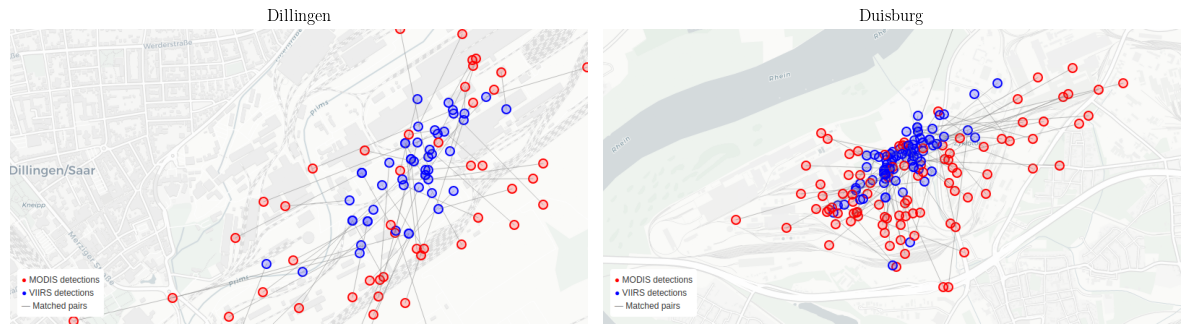

In [18]:
create_map_screenshot(
    type="matches",
    data=valid_matches_modis,
    center_coords=dillingen_coords,
    zoom_level=14.5,
    output_file='maps/dillingen_matches.png'
)
create_map_screenshot(
    type="matches",
    data=valid_matches_modis,
    center_coords=duisburg_coords,
    zoom_level=14,
    output_file='maps/duisburg_matches.png'
)
show_screenshots('maps/dillingen_matches.png', 'maps/duisburg_matches.png', 'Dillingen', 'Duisburg')

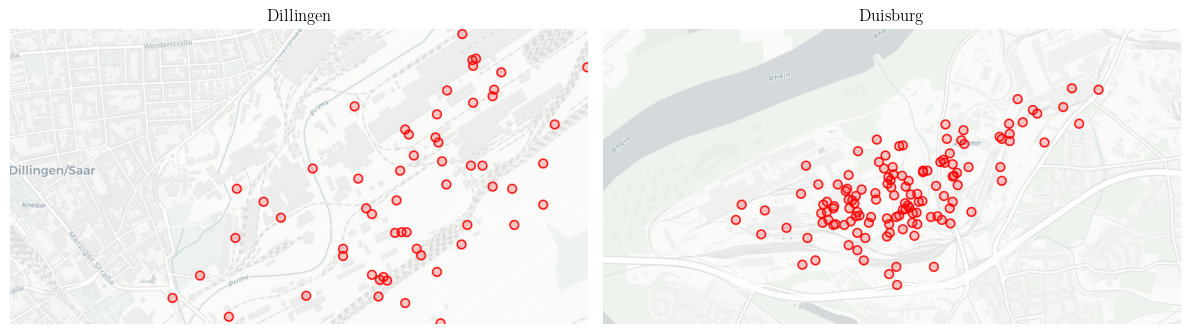

In [19]:
create_map_screenshot(
    type="single",
    data=modis_grouped_all,
    center_coords=dillingen_coords,
    zoom_level=14.5,
    output_file='maps/dillingen_detections_all.png'
)
create_map_screenshot(
    type="single",
    data=modis_grouped_all,
    center_coords=duisburg_coords,
    zoom_level=14,
    output_file='maps/duisburg_detections_all.png'
)
show_screenshots('maps/dillingen_detections_all.png', 'maps/duisburg_detections_all.png', 'Dillingen', 'Duisburg')

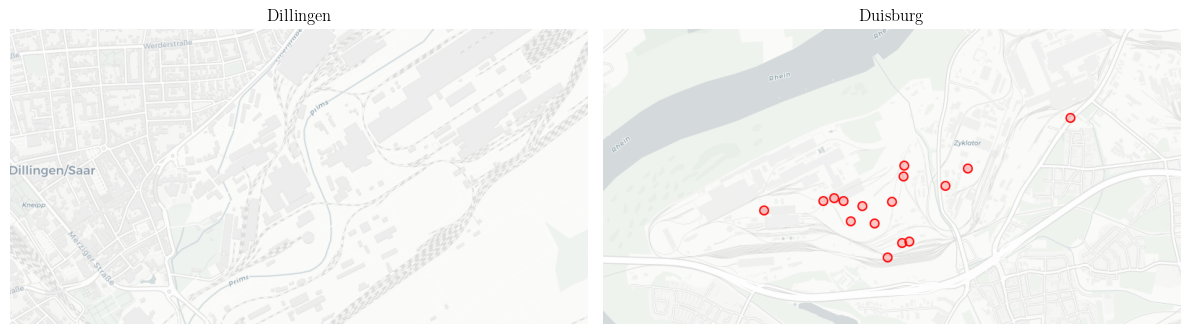

In [20]:
create_map_screenshot(
    type="single",
    data=modis_grouped_very_high_conf,
    center_coords=dillingen_coords,
    zoom_level=14.5,
    output_file='maps/dillingen_detections_very_high_conf.png'
)
create_map_screenshot(
    type="single",
    data=modis_grouped_very_high_conf,
    center_coords=duisburg_coords,
    zoom_level=14,
    output_file='maps/duisburg_detections_very_high_conf.png'
)
show_screenshots('maps/dillingen_detections_very_high_conf.png', 'maps/duisburg_detections_very_high_conf.png',
                 'Dillingen', 'Duisburg')

In [21]:
# get average confidence of very high confidence events in Duisburg area
max_distance_km = 2
modis_grouped_very_high_conf['distance'] = modis_grouped_very_high_conf.apply(
    lambda row: geodesic(duisburg_coords, (row['latitude'], row['longitude'])).km, axis=1)
duisburg_area_events = modis_grouped_very_high_conf[modis_grouped_very_high_conf['distance'] <= max_distance_km]
duisburg_area_events_100_confidence = duisburg_area_events[duisburg_area_events['confidence'] == 100]
print(f'Found {duisburg_area_events['event_id'].nunique()} events <= 2km from duisburg coords')
print(f'Number of those events with confidence 100%: {duisburg_area_events_100_confidence['event_id'].nunique()}')
print(f'Average confidence: {duisburg_area_events['confidence'].mean()}')

Found 16 events <= 2km from duisburg coords
Number of those events with confidence 100%: 5
Average confidence: 94.0625


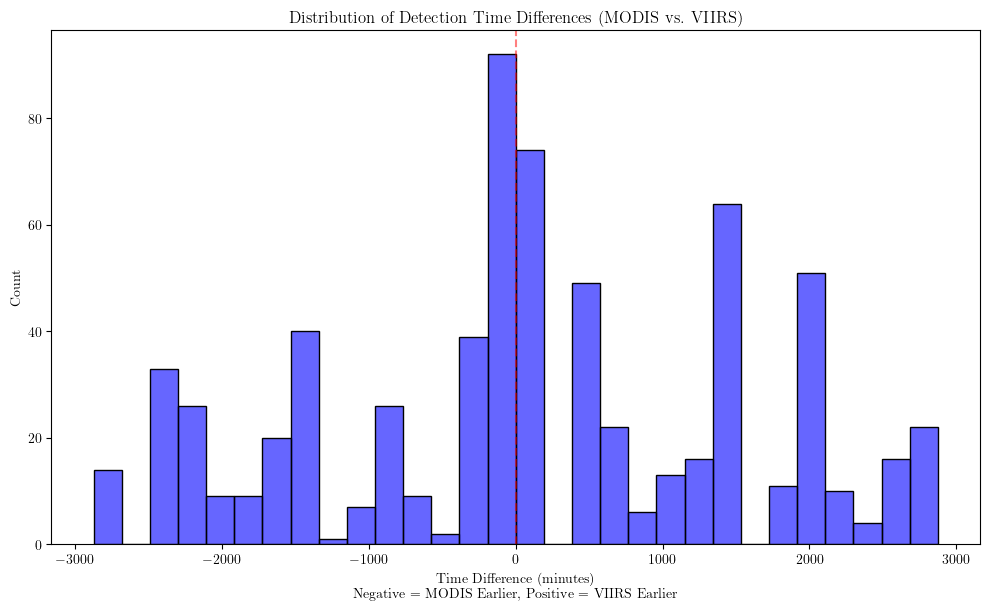

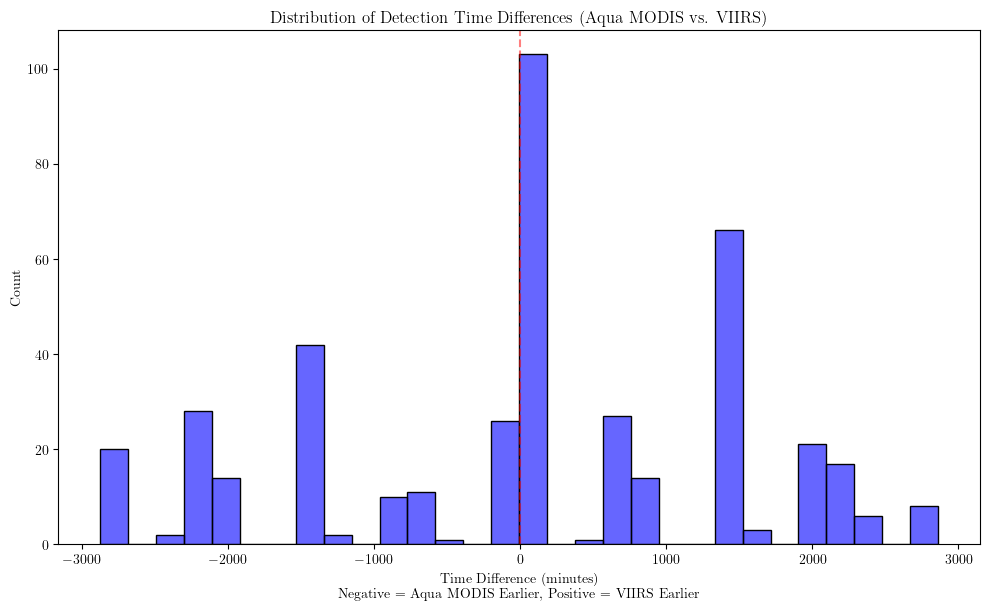

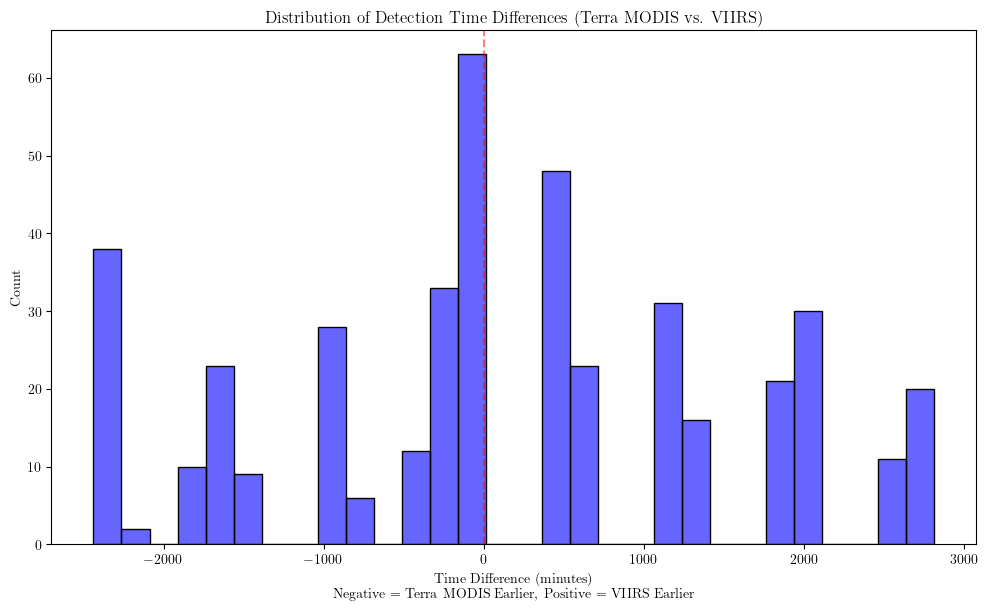

In [22]:
plot_histogram(valid_matches_modis, 'MODIS')
plot_histogram(valid_matches_aqua, 'Aqua MODIS')
plot_histogram(valid_matches_terra, 'Terra MODIS')
#plot_histogram(valid_matches_modis_all, 'MODIS (all)')

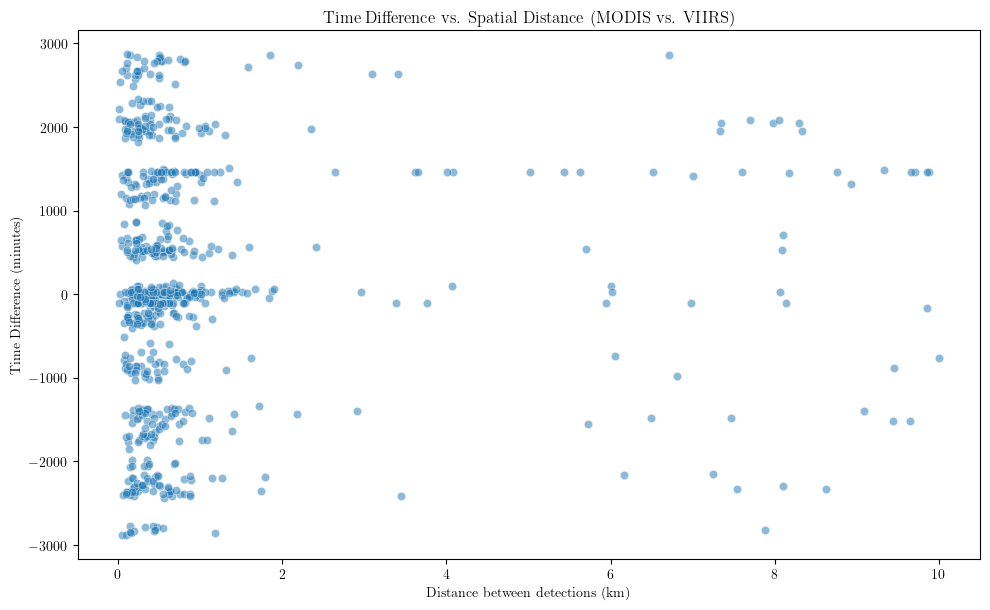

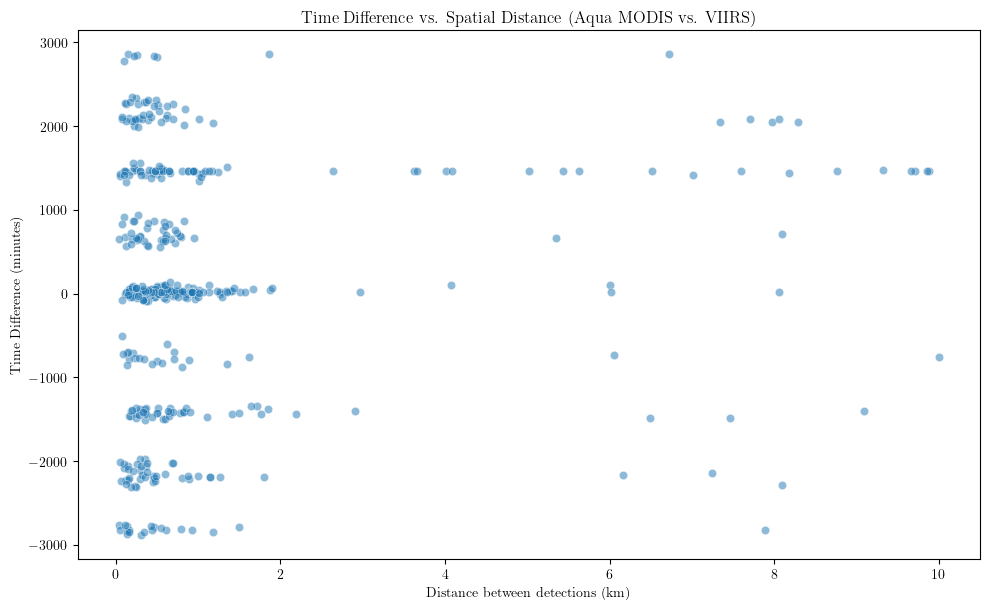

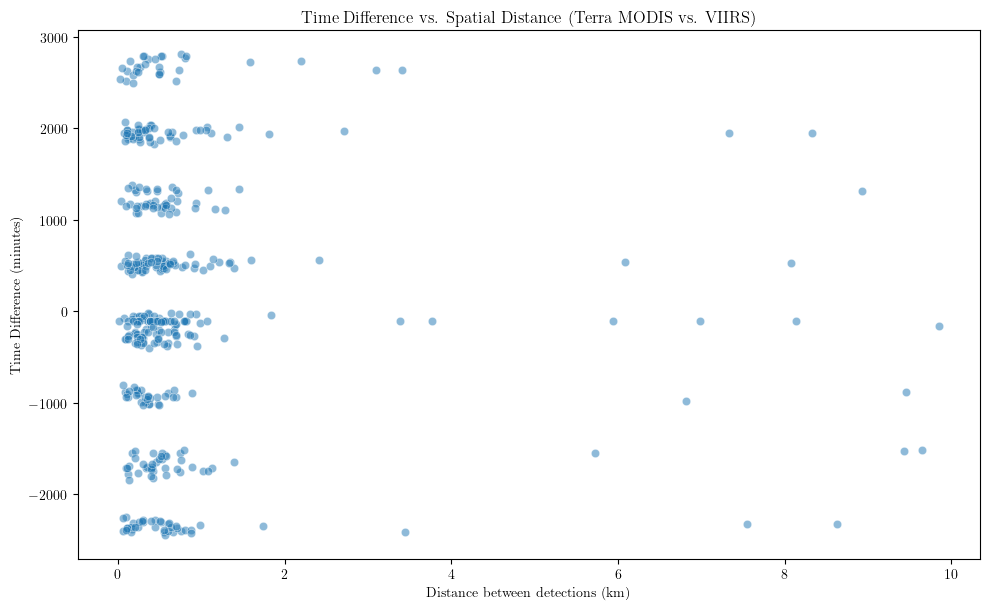

In [23]:
plot_time_distance(valid_matches_modis, 'MODIS')
plot_time_distance(valid_matches_aqua, 'Aqua MODIS')
plot_time_distance(valid_matches_terra, 'Terra MODIS')
#plot_time_distance(valid_matches_modis_all, 'MODIS (all)')